In [36]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import optuna

/home/ronald/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train = pd.read_csv('../datasets/processed/train.csv')

X_train, y_train = train.drop(['satisfaction'], axis=1), train['satisfaction']

In [4]:
validation = pd.read_csv('../datasets/processed/validation.csv')

X_validation, y_validation = validation.drop(['satisfaction'], axis=1), validation['satisfaction']

In [5]:
test = pd.read_csv('../datasets/processed/test.csv')

X_test, y_test = test.drop(['satisfaction'], axis=1), test['satisfaction']

# Model

In [15]:
import os, sys
CURRENT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(CURRENT_DIR+"/metrics.py"))

In [16]:


metrics = KsAucMetrics()

ImportError: cannot import name 'KsAucMetrics' from 'metrics' (/home/ronald/cod/redes-neurais/metrics.py)

In [8]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [9]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

In [20]:
y_pred_prob

array([0.99, 0.99, 0.  , ..., 0.  , 1.  , 0.  ])

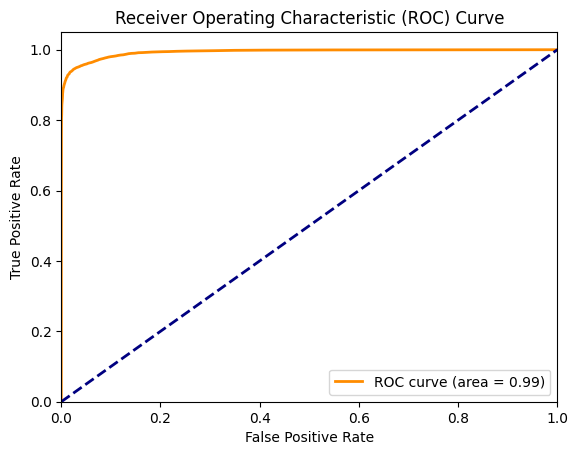

In [26]:
metrics.auc(y_pred_prob, y_test)

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [48]:
def auc(y_test, y_pred_prob):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [33]:
def ks_score(y_true, y_score):
    """ Calculating the Kolmogorov-Smirnov score"""
    fpr, tpr, _ = metrics.roc_curve(y_true, y_score)
    return max(tpr - fpr)

In [34]:
ks_score(y_test, y_pred_prob)

np.float64(0.9196478341726517)

In [37]:
def objective(trial):
    # Define the hyperparameter space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    max_features = trial.suggest_uniform('max_features', 0.1, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    # Create the model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Get probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate KS score
    ks = ks_score(y_test, y_pred_proba)
    
    return ks

In [39]:
# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Best parameters
print(study.best_params_)
print(study.best_value)

[I 2024-07-22 21:05:55,166] A new study created in memory with name: no-name-b433bae8-fbed-40ae-9a9c-cfc62236efea
[I 2024-07-22 21:06:08,559] Trial 0 finished with value: 0.9178793529043158 and parameters: {'n_estimators': 184, 'max_depth': 29, 'max_features': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9178793529043158.
[I 2024-07-22 21:06:16,247] Trial 1 finished with value: 0.8908878066743233 and parameters: {'n_estimators': 190, 'max_depth': 13, 'max_features': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9178793529043158.
[I 2024-07-22 21:06:27,412] Trial 2 finished with value: 0.9175396887680218 and parameters: {'n_estimators': 104, 'max_depth': 14, 'max_features': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9178793529043158.
[I 2024-07-22 21:06:42,915] Trial 3 finished with value: 0.9023282789848751 and parameters: {'n_estimators': 180, 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9178793529043158

AttributeError: 'Study' object has no attribute 'best_params_'

In [41]:
print(study.best_params)
print(study.best_value)

{'n_estimators': 148, 'max_depth': 24, 'max_features': 10, 'min_samples_leaf': 1}
0.9229837266613823


In [45]:
model = RandomForestClassifier(
        n_estimators=148,
        max_depth=24,
        max_features=10,
        min_samples_leaf=1,
        random_state=42
    )

In [46]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=24, max_features=10, n_estimators=148,
                       random_state=42)

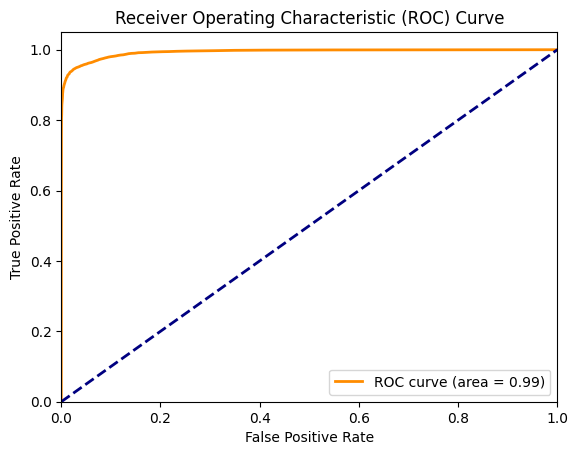

In [49]:
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

auc(y_test, y_pred_prob)